In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from astropy import units as u
from astropy import constants as const
from scipy.integrate import solve_bvp

# Project Step One: Cold Stream Properties

## Flow Velocity model

- Star Formation Rate of galaxy (efficieny)
- Number of flows
- Size of flow (covering fraction of galaxy disk)
- Density of gas

- Later: more self-consistent HD flow treatment (variable width, velocity, density)

- Time scale: use free fall time scale instead
\begin{equation}
    t_{ff} \sim \frac{1}{\sqrt{\rho G}}
\end{equation}

- Efficiency: $10\% \sim 30\%$ for SFR
- Cross-section: covers $10\% \sim 50\%$ of the Galaxy
- General result/value for the flow rate:
\begin{equation}
    Q \approx 1000 \sim 10000 km/s
\end{equation}

- Equation:

\begin{equation}
    Q(\epsilon_{SF}) = (\frac{1}{{N_{F}}{\epsilon_{SF}}}) * (\frac{M_{F}}{{\rho_{F}}{A_{F}}{t_{dyn}}}) = (\frac{1}{{N_{F}}{\epsilon_{SF}}}) * (\frac{R_{SF}}{{\rho_{F}}{A_{F}}})
\end{equation}

In [2]:
## Fixed Variables
M_F = 5E11 * u.solMass # How much total mass does the flows have

G = const.G # The Gravitational Constant

N_F = 3 * u.dimensionless_unscaled # Number of flows that are present for the model

A_F = (np.pi) * (2000 * u.pc) * (2000 * u.pc) # The corss section of the stream (or the pipe) of flow

rho_F = 1E-19 * ((1*u.kg) * (1/u.m) * (1/u.m) * (1/u.m)) # The density of the stream

t_dyn = 1 / np.sqrt(rho_F * G) # The free fall time for gas to fall into Galaxy

e_SF1 = 0.1 * u.dimensionless_unscaled # Star formation efficieny at 10%
e_SF2 = 0.2 * u.dimensionless_unscaled # Star formation efficieny at 20%
e_SF3 = 0.3 * u.dimensionless_unscaled # Star formation efficieny at 30%

## Varying Variables
R_SF = np.linspace(3, 100, num=100)*(1 * u.solMass)*(1/u.yr) # Star Formation Rate 
                                    # (usual value of 3 M_sol/yr to starburst value of 100M_sol/yr)

## Function for flow rate (linear)

def Q(e):
    a = 1/ (N_F * e)
    b = rho_F * A_F
    c = R_SF / b
    d = a * c
    e = d.decompose()
    return e.to(u.km/u.s)

Text(0.5, 1.0, 'Flow Velocity vs Star Formation Rate')

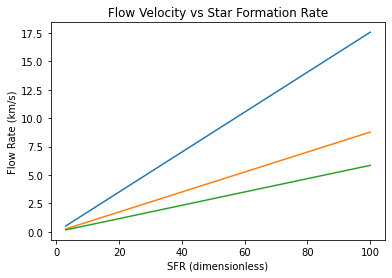

In [3]:
## Plots for the initial model
plt.plot(R_SF, Q(e_SF1))
plt.plot(R_SF, Q(e_SF2))
plt.plot(R_SF, Q(e_SF3))
plt.xlabel("SFR (dimensionless)")
plt.ylabel("Flow Rate (km/s)")
plt.title("Flow Velocity vs Star Formation Rate")

# Project Step 2: Accretion Flow Model

- Usually need 3 equations to deal with a thermal fluid flow

- Let's try a simple isothermal inflow model (so can avoid dealing with the energy equation for now)
\begin{equation}
    P = c^2_{s} \rho
\end{equation}
- $c^2_{s}$ is the sound speed

- For infow rate, same as before (SFR, efficieny), and this can be fixed for now
\begin{equation}
    \dot{M} = 4\pi r^2 \rho v
\end{equation}

- Dealing things in spherical coordinates

- Mass Continuity:
\begin{equation}
    \frac{1}{r^2} \frac{d}{dr} (r^2 \rho v) = 0
\end{equation}

- Momentum:
\begin{equation}
    \rho v \frac{dv}{dr} = -\frac{dP}{dr} - \rho\frac{GM}{r^2}
\end{equation}

- Boundary condition at a point where velocity is soundspeed, where $\frac{dv}{dr} = 0$

## Task
- Try to make a plot for $\rho(r)$ and $v(r)$, where $r$ is in units of $r_s$
- Try analytical and numerical (python odeint solver)
- Deal with CR effect later (there are some forces from their pressure gradient, and energy from CR heating - so won't be isothermal)

## Key Equations and Analysis

\begin{equation}
    c_{s} = \sqrt{\frac{GM}{2r_{s}}} \Leftarrow\Rightarrow r_{s} = \frac{GM}{2c^2_{s}}
\end{equation}

- Overall, equations are very sensitive to initial coniditons and boundary conditions
- For outflow solution:
    - Expect terminal velocity to be reached
    - Density should decrease with radius
\begin{equation}
    \frac{dv}{dr} = - \frac{c^2_{s}}{\rho v} \frac{d\rho}{dr} - \frac{GM}{vr^2}
\end{equation}

\begin{equation}
    \frac{dv}{dr} \approx  - \frac{GM}{vr^2}
\end{equation}

\begin{equation}
    \frac{dv}{dr} = 0
\end{equation}

\begin{equation}
    \frac{d\rho}{dr} = - \frac{\rho}{v} \frac{dv}{dr} - \frac{2}{r} \rho
\end{equation}

\begin{equation}
    \frac{d\rho}{dr} = \frac{\rho}{1 - \frac{c^2_{s}}{v^2}} (\frac{GM}{v^2 r^2} - \frac{2}{r})
\end{equation}

- For the expression $\frac{dv}{dr}$:
    - The first one is the general expression
    - The second one is when it is near $r = r_s$ where we can estimate that $\frac{d\rho}{dr}$ is zero 
    - The third one is when it is at the critical radius $r_s$

- for the expression $\frac{d\rho}{dr}$: 
    - The first one is in terms of $\frac{dv}{dr}$
    - The second one is the general expression

### Revised Boundary Conditions for Outflow solution
- For $v(r)$:
    - Lower bound: the sound speed $c_s$
    - Upper bound: a terminal velocty $v_t$, most likely use general terminal velocity expression

- For $\rho(r)$:
    - Upper bound: $0$, since at an infinite distance the density should tend to zero

## Rescaled Functions with $x = \frac{r}{r_s}$

In [4]:
GM =((const.G)*(1E9*u.solMass)).decompose() # [m^3/s^2]

def fun_accret(x, y, p):
    r_s = (p[0]*1000*(u.pc)).decompose() #the critical radius  [m]
    
    c_s_2 = (GM / (2*r_s)) #c_s^2 [m^2/s^2]
    
    v = y[0]*(u.m/u.s) # v(r) [m/s]
    
    rho = y[1]*(u.kg/(u.m**3)) #rho(r) [kg/m^3]
    
    # return value is dv/dr, drho/dr
    
    drho_units = ((rho / (1 - (c_s_2 / v**2)))*(((2*c_s_2)/((v**2)*((x)**2))) - (2/(x)))) #drho/dr [kg/m^3]
    
    #drho1 = (rho / (1 - (c_s_2 / v**2)))
    #drho2 = ((2*c_s_2)/((v**2)*((x)**2)))
    #drho3 =  - (2/(x))
    
    drho = (drho_units.to("kg/m^3")).value
    
    dv1_units = - (c_s_2 / v)*(((1/rho)*(drho_units)) + (2/(x)**2)) #dv/dr [m/s]
    
    #dv11 = - (c_s_2 / v)
    #dv12 = (1/rho)*(drho_units)
    #dv13 = (2/(x)**2)
    
    dv1 = (dv1_units.to("km/s")).value
    
    dv2_units = - (GM/(v*r_s*((x)**2))) #dv/dr [m/s]
    
    dv2 = (dv2_units.to("km/s")).value
    
    if np.any(x == 1):
        return np.vstack((dv2, drho))
    else:
        return np.vstack((dv1, drho))
    
    #print(dv11, dv12, dv13)

def bc_accret(ya, yb, p):
    r_s = (p[0]*1000*(u.pc)).decompose() #the critical radius [m]
    
    c_s_2 = (GM / (2*r_s)) #c_s^2 [m^2/s^2]
    
    return np.array([ya[0] - ((np.sqrt(c_s_2)).to("m/s")).value, 
                     yb[0] - ((12000*(u.km/u.s)).to("m/s")).value, 
                     yb[1] - ((1E-3)*(1.67E-27)*(u.kg/(u.m**3))).value])

x_accret = np.linspace(1, 1000, 1000)
y_accret = np.ones((2, x_accret.shape[0]))

In [5]:
res_accret = solve_bvp(fun_accret, bc_accret, x_accret,
                              y_accret, p=[1], verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.48e+06       7.50e+05         1000          (1998)     
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 2.48e+06 
Maximum boundary residual: 7.50e+05


/Users/stevenhsueh/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/stevenhsueh/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


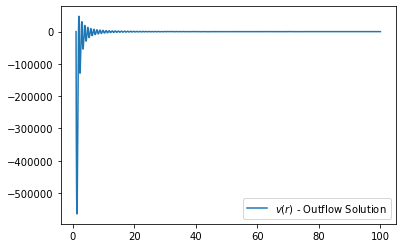

In [6]:
x_accret_plot = np.linspace(1, 100, 1000)
y_accret_plot = res_accret.sol(x_accret_plot)

#Plot for v(r)

plt.plot(x_accret_plot, y_accret_plot[0], label="$v(r)$ - Outflow Solution")
plt.legend()

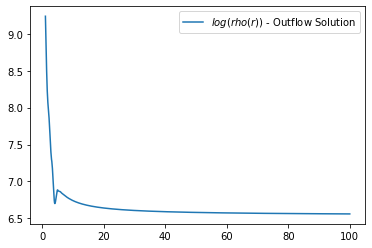

In [7]:
#Plot for rho(r) scaled with log
plt.plot(x_accret_plot, np.log(y_accret_plot[1]), label="$log(rho(r))$ - Outflow Solution")
plt.legend()

## Rescaled With Both Axis - Fourth-Order Runge-Kutta Methods
- Issues with units in the equations have been fixed, however, we clearly see a divergence behavour in the $v(r)$ plot
- Next we will also try to rescale both $v(r)$ and $\rho(r)$ with a reasonable choice of scale factors
    - For $v(r)$, we will be scaling the function with $c_{s}$ which is the sound speed and is also the value of the velocity at $ r = r_{s}$; this allows us to have starting value of the graphs at (1,1)
    - For $\rho(r)$, we will be scaling the function with $\rho_{c}$ which is an arbitrary density of the gas at the critical radius, and it can be defined as followed:
    
   \begin{equation}
       \rho_{0} = \frac{M_{rate}}{4 \pi c_{s} r^2_{s}}
   \end{equation}
   - where $M_{rate}$ is the mass injection rate from SN activity and feedback
   - We will came to know that this arbitrary scale factor for the density will not show up in our rescaled ODEs, and only serves as a placeholder to help us get a trivial solutions

\begin{equation}
    x = \frac{r}{r_s}
\end{equation}

\begin{equation}
    f(x) = \frac{v(r)}{c_s}
\end{equation}
    
    
\begin{equation}    
    h(x) = \frac{\rho(r)}{\rho_0}
\end{equation}

In [8]:
#Defining functions

#dh/dx (the original drho/dr)
def dhdx(x, f, h):
    return h*((1 - (1/f**2))**(-1))*((2/((x**2)*(f**2))) - (2/x))

#df/dx (the original dv/dr)
def dfdx(x, f, h):
    return (-1/f)*((1/h)*(dhdx(x, f, h)) + (2/x**2))

iterations = 1000000 #resolutions

x0 = 1.00001
x_max = 100

X = np.linspace(x0, x_max, iterations) #range of our x-axis
x_step = (x_max - x0)/iterations


# Initials value for f(x) and h(x)
f = 1.00001
h = 1 # Placeholder for initial assumptions (The graph is sensitive to this value)

# Empty arrays for appending values
F = []
H = []

# while true -> x+= x_step (potentially adding for checking end value)

# Loop used for solving the ODEs
for x in X:
    kh1 = x_step * dhdx(x, f, h)
    kf1 = x_step * dfdx(x, f, h)
    
    kh2 = x_step * dhdx(x+0.5*x_step, f+0.5*kf1, h+0.5*kh1)
    kf2 = x_step * dfdx(x+0.5*x_step, f+0.5*kf1, h+0.5*kh1)
    
    kh3 = x_step * dhdx(x+0.5*x_step, f+0.5*kf2, h+0.5*kh2)
    kf3 = x_step * dfdx(x+0.5*x_step, f+0.5*kf2, h+0.5*kh2)
    
    kh4 = x_step * dhdx(x+x_step, f+kf3, h+kh3)
    kf4 = x_step * dfdx(x+x_step, f+kf3, h+kh3)
    
    h += (kh1 + 2*kh2 + 2*kh3 + kh4)/6
    f += (kf1 + 2*kf2 + 2*kf3 + kf4)/6
    
    H.append(h)
    F.append(f)

In [9]:
# Looking for the value that the functions are tending to overall
print(F[-1], H[-1])
# The values are in ratio with the scaling factors

4.286195174148395 2.333158407713418e-05


Text(0.5, 1.0, 'Outflow Solution for v(r)')

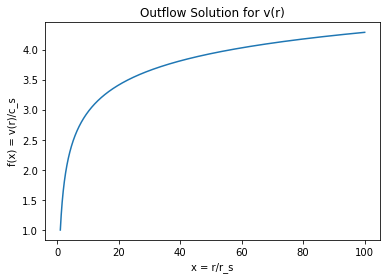

In [10]:
plt.plot(X, F)
plt.xlabel("x = r/r_s")
plt.ylabel("f(x) = v(r)/c_s")
plt.title("Outflow Solution for v(r)")

Text(0.5, 1.0, 'Outflow Solution for log(rho(r))')

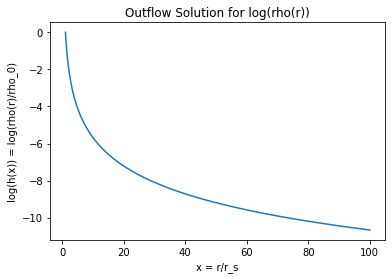

In [11]:
plt.plot(X, np.log(H))
plt.xlabel("x = r/r_s")
plt.ylabel("log(h(x)) = log(rho(r)/rho_0)")
plt.title("Outflow Solution for log(rho(r))")

# Project Step 3 - Accretion Flow with Cosmic Rays
- Same as before, but now with a CR flow component, where pressure gradients affect the HD properties
- Mass Continuity:
\begin{equation}
        \frac{1}{r^2} \frac{d}{dr} (r^2 \rho v) = 0
\end{equation}

- Momentum:
\begin{equation}
    \rho v\frac{dv}{dr} = -\frac{dP}{dr} - \frac{d{P_C}}{dr} - \rho\frac{GM}{r^2}
\end{equation}

- Cosmic Ray energy equation:
    - $\gamma_C = 4/3$
    - $\gamma_g = 5/3$
\begin{equation}
    \frac{1}{r^2} \frac{d}{dr} [\rho (v + v_A) r^2 \frac{\gamma_C}{\gamma_C - 1} \frac{P_C}{\rho}] = -I
\end{equation}

- Thermal Gas energy equation: 
\begin{equation}
    \frac{1}{r^2}\frac{d}{dr}[\rho v r^2(\frac{v^2}{2} + \frac{\gamma_g}{\gamma_g - 1} \frac{P}{\rho})] = -\rho v \frac{GM}{r^2} + I
\end{equation}

- Energy Transfer Rate between CR and thermal fluids:
\begin{equation}
    I = -(v + v_A) \frac{d{P_C}}{dr}
\end{equation}

\begin{equation}
    v_A = \tilde{v_{A}} = \frac{r^2_s \sqrt{<B^2>}}{r^2\sqrt{4\pi\rho}}
\end{equation}

- $P$ is the thermal gas pressure, while $P_C$ is the cosmic ray pressure

## Result From $B. P. B. Yu et al.$ and $S. Samui, K. Subramanian, R. Sri anand$

\begin{equation}
    \frac{dv}{dr} = \frac{2vc^2_s - \frac{GM}{r}v}{r(v^2 - c^2_s)}
\end{equation}

\begin{equation}
    \frac{dM}{dt} = 4\pi\rho v r^2 = const
\end{equation}

\begin{equation}
    \frac{d\rho}{dr} = \frac{1}{v^2}(\frac{dP}{dr} +\frac{dP_C}{dr} +\rho \frac{GM}{r^2}) - \frac{2}{r}\rho
\end{equation}

\begin{equation}
    \frac{dP_C}{dr} = \frac{\gamma_C P_C}{\rho} \frac{2v + v_A}{2(v + v_A)} \frac{d\rho}{dr}
\end{equation}

\begin{equation}
    \frac{dP}{dr} = (\frac{\gamma_g P}{\rho} - \frac{\gamma_C P_C}{\rho}\frac{\gamma_g - 1}{2}\frac{v_{A}(2v+v_A)}{v(v+v_A)})\frac{d\rho}{dr}
\end{equation}

\begin{equation}
    c^2_s = \frac{\gamma_g P_C}{\rho} + \frac{\gamma_C P_C}{\rho}\frac{(2v + v_A)(v - (\gamma_g - 1)v_A)}{2v(v + v_A)} 
\end{equation}

\begin{equation}
    v_A = \tilde{v_{A}} = \frac{r^2_s \sqrt{<B^2>}}{r^2\sqrt{4\pi\rho}}
\end{equation}



## Rescaling the Result Equations
- $r = r_s x$ and $v = c_s u$ and $V_c$ being the circular velocity of the gas at the critical radius is $\sqrt{\frac{GM}{r_s}}$

\begin{equation}
    \frac{dv}{dr} \Rightarrow \frac{du}{dx} = \frac{2u - (\frac{V_c}{c_s})^2 \frac{u}{x}}{x(u^2 - 1)}
\end{equation}

- For $v + v_A$ and $\rho = \rho_s y$:

\begin{equation}
    v_A = \tilde{v_{A}} = \frac{r^2_s \sqrt{<B^2>}}{r^2\sqrt{4\pi\rho}} \Rightarrow v^2_A = \frac{8\pi U_{B,0}}{4\pi \rho_s} \frac{1}{x^4 y} = \frac{v^2_{A,0}}{x^4 y}
\end{equation}
\begin{equation}
    v + v_A = u c_s + \frac{v_{A,0}}{x^2 \sqrt{y}} = v_{eff}
\end{equation}

- $r = r_s x$ and $\rho = \rho_s y$ and $P_C = P_{C,0} \theta_C $ where $ P_{C,0}$ is the cosmic ray pressure at the critical radius
\begin{equation}
    \frac{dP_C}{dr} \Rightarrow \frac{d\theta_C}{dx} = \frac{\theta_C}{y} \frac{uc_s + v_{eff}}{2v_{eff}} \frac{dy}{dx}
\end{equation}

- $r = r_s x$ and $\rho = \rho_s y$ and $P = P_{0} \theta $ where $ P_{0}$ is the thermal gas pressure at the critical radius
\begin{equation}
    \frac{dP}{dr} \Rightarrow \frac{d\theta}{dx} = (\frac{5\theta}{3y} - \frac{4\theta_C}{9y} R_{CT} \frac{\frac{v_{A,0}}{x^2 \sqrt{y}}(uc_s + v_{eff})}{uc_s v_{eff}}) \frac{dy}{dx}
\end{equation}

\begin{equation}
R_{CT} = \frac{P_{C,0}}{P_0}
\end{equation}

- $r = r_s x$ and $\rho = \rho_s y$:
\begin{equation}
    \frac{d\rho}{dr} \Rightarrow \frac{dy}{dx} = \frac{1}{u^2 c^2_s} (R_{T\rho }\frac{d\theta}{dx} + R_{C\rho } \frac{d\theta_c}{dx}  + \frac{y V^2_c}{x^2}) - \frac{2 y}{x}
\end{equation}

\begin{equation}
R_{T\rho } = \frac{P_0}{\rho_s}, R_{C\rho } = \frac{P_{C,0}}{\rho_s}
\end{equation}

## Step 3 with Fourth-Order Runge-Kutta Methods - Simple Sound Speed Version

In [12]:
# Global Variables
GM =((const.G)*(1E9*u.solMass)).decompose()
r_s = (1000*u.pc).decompose() # critical radius
V_c = np.sqrt(GM / r_s) # Thermal Gas Circular Velocity at critical radius
c_s = np.sqrt(GM / (2*r_s)) # Sound Speed (Isothermal Case)
U_B0 = ((1E-15)*(u.erg/(u.cm**3))).decompose() # Constant Magnetic Energy Density in the Galaxy
rho_s = 1*(1.67E-27)*(u.kg/(u.m**3)) # Density at critical radius
R_CT = 2 # Ratio between Cosmic Ray Pressure and Thermal Gas Pressure
R_Trho = (50*(u.Pa /(u.kg/(u.m**3)))).decompose() # Ratio between Thermal Gas Pressure and density
R_Crho = (75*(u.Pa /(u.kg/(u.m**3)))).decompose() # Ration between Cosmic Ray Pressure and density
v_A0_2 = ((8*np.pi*U_B0) /(4*np.pi*rho_s)).decompose() # Alfven Velocity at critical radius


#Checking Units
#print(GM, r_s, V_c, c_s, B_0, rho_s, R_Trho, R_Crho)
#print(np.sqrt(v_A0_2), c_s**2, U_B0)

In [18]:
# Defining functions

# v_eff (original v + v_A)
def v_eff(x, y, u):
    v = c_s * u
    v_A = np.sqrt(v_A0_2) / ((x**2)*np.sqrt(y))
    return v + v_A

# du/dx (original dv/dr)
def dudx(x, u):
    num = 2*u - ((V_c/c_s)**2)*(u/x)
    dem = x*(u**2 - 1)
    return num/dem

# dtheta_c/dx (original dP_c/dr)
def dtheta_cdx(y, theta_c, u):
    a = theta_c/y
    b = (u*c_s + v_eff(x, y, u))/(2*v_eff(x, y, u))
    c = dydx(x, y, u)
    return a*b*c

# dtheta/dx (original dP/dr)
def dthetadx(theta, theta_c, y, u):
    a = (5*theta)/(3*y)
    b = ((4*theta_c)/(9*y))*R_CT
    c = ((np.sqrt(v_A0_2)/((x**2)*np.sqrt(y)))*(u*c_s + v_eff(x, y, u)))/(u*c_s*v_eff(x, y, u))
    return (a - b*c)*dydx(x, y, u)

# dy/dx (original drho/dr)
def dydx(x, y, u):
    a = 1/((u**2)*(c_s**2))
    b = R_Trho*dthetadx(theta, theta_c, y, u)
    c = R_Crho*dtheta_cdx(y, theta_c, u)
    d = (y*(V_c**2))/(x**2)
    e = (2*y)/x
    return a*(b+c+d) - e


In [22]:
# Iterations & Integrations
Iteration = 100 #resolution (can change for better result)

#Initial value for x and step counts
x02 = 1
x_max2 = 100

X2 = np.linspace(x02, x_max2, Iteration) #range of x-axis that we are integrating
x_step2 = (x_max2 - x02)/Iteration

# Initial values for all functions (can change to adjust whenever)
u = 1.1 # Velocity
y = 1 # Density
theta = 1 # Thermal Gas Pressure
theta_c = 1 # Cosmic Ray Pressure

# Empty Arrrays for Appending All Unknown Functions
U = []
Y = []
Theta = []
Theta_C = []

# Integration Process
for x in X2:
    ku1 = x_step2 * dudx(x, u)
    ktheta_c1 = x_step2 * dtheta_cdx(y, theta_c, u)
    ktheta1 = x_step2 * dthetadx(theta, theta_c, y, u)
    ky1 = x_step2 * dydx(x, y, u)
    
    ku2 = x_step2 * dudx(x+0.5*x_step2, u+0.5*ku1)
    ktheta_c2 = x_step2 * dtheta_cdx(y+0.5*ky1, theta_c+0.5*ktheta_c1, u+0.5*ku1)
    ktheta2 = x_step2 * dthetadx(theta+0.5*ktheta1, theta_c+0.5*ktheta_c1, y+0.5*ky1, u+0.5*ku1)
    ky2 = x_step2 * dydx(x+0.5*x_step2, y+0.5*ky1, u+0.5*ku1)
    
    ku3 = x_step2 * dudx(x+0.5*x_step2, u+0.5*ku2)
    ktheta_c3 = x_step2 * dtheta_cdx(y+0.5*ky2, theta_c+0.5*ktheta_c2, u+0.5*ku2)
    ktheta3 = x_step2 * dthetadx(theta+0.5*ktheta2, theta_c+0.5*ktheta_c2, y+0.5*ky2, u+0.5*ku2)
    ky3 = x_step2 * dydx(x+0.5*x_step2, y+0.5*ky2, u+0.5*ku2)
    
    ku4 = x_step2 * dudx(x+x_step2, u+ku3)
    ktheta_c4 = x_step2 * dtheta_cdx(y+ky3, theta_c+ktheta_c3, u+ku3)
    ktheta4 = x_step2 * dthetadx(theta+ktheta3, theta_c+ktheta_c3, y+ky3, u+ku3)
    ky4 = x_step2 * dydx(x+x_step2, y+ky3, u+ku3)
    
    u += (ku1 +2*ku2 + 2*ku3 + ku4)/6
    theta_c += (ktheta_c1 + 2*ktheta_c2 + 2*ktheta_c3 + ktheta_c4)/6
    theta += (ktheta1 + 2*ktheta2 + 2*ktheta3 + ktheta4)/6
    y += (ky1 +2*ky2 + 2*ky3 + ky4)/6
    
    U.append(u)
    Theta_C.append(theta_c)
    Theta.append(theta)
    Y.append(y)

RecursionError: maximum recursion depth exceeded

In [ ]:
plt.plot(X2, U)
plt.xlabel("x = r/r_s")
plt.ylabel("u(x) = v(r)/c_s")
plt.title("Outflow Solution for v(r)")

In [ ]:
plt.plot(X2, np.log(Y))
plt.xlabel("x = r/r_s")
plt.ylabel("log(y(x)) = log(rho(r)/rho_s)")
plt.title("Outflow Solution for log(rho(r))")

In [ ]:
plt.plot(X2, Theta_C)
plt.xlabel("x = r/r_s")
plt.ylabel("theta_c(x) = P_C(r)/P_C,0")
plt.title("Outflow Solution for P_C(r)")

In [ ]:
plt.plot(X2, Theta)
plt.xlabel("x = r/r_s")
plt.ylabel("theta(x) = P(r)/P_0")
plt.title("Outflow Solution for P(r)")